In [1]:
import os
os.chdir('../../src/')
from visualization.SIR_Plot import make_SIR_graph, make_beds_graph

In [2]:
os.chdir('models')
import simulate_pandemic as simp
from actions import city_restrictions, costs

Loading Graph...Done!


In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [54]:
import plotly.graph_objects as go

def make_beds_graph(data, std, actions, sample_curve, step_size, title, color_map=None, make_df=True):
    fig = go.Figure()
    
    if make_df:
        data = pd.DataFrame([pd.Series(d).value_counts() for d in data])
        data.fillna(0, inplace=True)

    color_map = {
        'Lockdown':          'rgb(0.83, 0.13, 0.15)',
        'Hard Quarantine':    'rgb(0.85, 0.35, 0.13)',
        'Light Quarantine':   'rgb(0.97, 0.91, 0.56)',
        'Social Distancing':  'rgb(0.67, 0.88, 0.69)',
        'Unrestricted':        'rgb(0.86, 0.86, 0.86)'    
    }

    pop = 55492

    actions = list(map(color_map.get,  actions))

    x = list(range(len(data)+1))
  

    # HOSPITALIZED LINE #####################################################################################
    #\definecolor{royalblue(web)}{rgb}{0.25, 0.41, 0.88}
    fig.add_trace(go.Scatter(x=x, y=data[3]/pop, name='hospitalized', line_color = 'rgb(0.25, 0.41, 0.88)',
                            line=dict(width=4), 
                            # yaxis="y2"
                            ))
    
    fig.add_trace(go.Scatter(x=x, y=(data[3]/pop) + (std[3]/pop), fill=None, mode='lines', showlegend=False,
                            #yaxis="y2",
                            line_color='rgb(0.35, 0.51, 0.98)'))
    
    
    fig.add_trace(go.Scatter(x=x, y=(data[3]/pop), fill='tonexty', mode='lines', 
                             #yaxis="y2",
                             line_color='rgb(0.35, 0.51, 0.98)', name="Standard Deviation"))
    
    fig.add_trace(go.Scatter(x=x, y=(data[3]/pop) - (std[3]/pop), fill=None, mode='lines', 
                             #yaxis="y2",
                             line_color='rgb(0.35, 0.51, 0.98)',    showlegend=False))


    fig.add_trace(go.Scatter(x=x, y=(data[3]/pop), fill='tonexty', mode='lines',
                             #yaxis="y2",
                             line_color='rgb(0.35, 0.51, 0.98)',     showlegend=False))
    
    # EXPOSED LINE #########################################################################################
    """fig.add_trace(go.Scatter(x=x, y=data[1]/pop, name='hospitalized', line_color = 'rgb(0.7, 0.13, 0.13)',
                            line=dict(width=4),  yaxis="y1"))
    
    fig.add_trace(go.Scatter(x=x, y=(data[1]/pop) + (std[1]/pop), fill=None, mode='lines', showlegend=False,
                            yaxis="y1", line_color='rgb(0.8, 0.23, 0.23)'))
    
    
    fig.add_trace(go.Scatter(x=x, y=(data[1]/pop), fill='tonexty', mode='lines', 
                             yaxis="y1", line_color='rgb(0.8, 0.23, 0.23)', name="Standard Deviation"))
    
    fig.add_trace(go.Scatter(x=x, y=(data[1]/pop) - (std[1]/pop), fill=None, mode='lines', 
                             yaxis="y1", line_color='rgb(0.8, 0.23, 0.23)',    showlegend=False))


    fig.add_trace(go.Scatter(x=x, y=(data[1]/pop), fill='tonexty', mode='lines',
                             yaxis="y1", line_color='rgb(0.8, 0.23, 0.23)',     showlegend=False))

    """
    # CAPACITY LINE ################################################################################
    fig.add_trace(go.Scatter(x=x, y=len(data)*[0.0015], name='capacity', line_color = 'black',
                            line=dict(dash='dash', width = 2)
                             #, yaxis="y2"
                            ))
    #################################################################################################
    
    # ACTIONS BACKGROUND################################################################################
    fig.update_layout(
        shapes=[
            dict(
                type="rect",
                # x-reference is assigned to the x-values
                xref="x",
                # y-reference is assigned to the plot paper [0,1]
                yref="paper",
                x0=x[step_size*i],
                y0=0,
                x1=x[step_size*(i+1)],
                y1=1,
                fillcolor=a,
                opacity=0.45,
                layer="below",
                line_width=0,
            ) for i,a in enumerate(actions)] 
    )
    
    # LAYER OF SAMPLE SIMULATION ##########################################################
    fig.add_trace(go.Scatter(x=x, y=sample_curve[3]/pop, name='sample_curve', line_color = 'rgb(0, 0, 0)',
                        line=dict(width=2, ), 
                        # yaxis="y2"
                        ))

    # GHOST TRACES FOR LEGEND#############################
    for k,v in color_map.items():
        fig.add_trace(go.Bar(x=[None], y=[None], marker=dict(color=v), name = k))

    fig.update_layout( xaxis={'showgrid': False,},
                      yaxis = {'showgrid': False, 'zeroline': False}, showlegend=False, hovermode="x")
    
    
    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = list(range(0, len(data)+1, 14)),
            ticktext = list(range(0, int(len(data)/7) + 1, 2)),
            title = 'Weeks'
            ),
        showlegend=False,
        margin=dict(
            l=50,
            r=50,
            b=50,
            t=50,
            pad=0
    ))


    fig.update_yaxes(automargin=True)
    fig.write_image(f"{title}.pdf")

    fig.show()

In [33]:
def run_simulation(policy, step_size = 7, days = 364):
    pop_matrix = simp.init_infection()

    data = []
    actions = []
   
    for day in tqdm(range(1, days+1)):
        #if less than 20% still susceptible, break simulation
        if np.sum(pop_matrix[:,1] == -1) > pop_matrix.shape[0]*.9: break
            
        # Choose a new policy at each week
        if day % step_size == 1:
            action = policy(np.sum(pop_matrix[:,1] == 3)/pop_matrix.shape[0], day)
            restrictions = city_restrictions[action]
            actions.append(action)

        pop_matrix = simp.spread_infection(pop_matrix, restrictions, day)
        pop_matrix = simp.lambda_leak_expose(pop_matrix, day)
        pop_matrix = simp.update_population(pop_matrix)
            
        data.append(pd.Series(pop_matrix[:,1]).value_counts())
        #data.append(np.array(sorted(pop_matrix, key=lambda x: x[0]))[:, 1])

    #return data, actions, contacts_infected, pop_matrix
    return data, actions

In [108]:
def unrestricted(hosp, day):
    return 'Unrestricted'

def early_end(day):
    if day < 35:
        return 'Unrestricted'
    if day <= 126: 
        return 'Light Quarantine'
    return 'Social Distancing'
    
    
def half_policy(hosp):
    if hosp >= 0.0015/2: return 'Lockdown'
    if hosp >= 0.00125/2: return 'Hard Quarantine'
    if hosp >= 0.001/2: return 'Light Quarantine'
    if hosp >= 0.0005/2: return 'Social Distancing'
    return 'Unrestricted'

def third_policy(hosp, day):
    if hosp >= 0.0015/3: return 'Lockdown'
    if hosp >= 0.00125/3: return 'Hard Quarantine'
    if hosp >= 0.001/3: return 'Light Quarantine'
    if hosp >= 0.0005/3: return 'Social Distancing'
    return 'Unrestricted'

def irregular_policy(hosp, day):
    if hosp >= 0.0015/1.5: return 'Lockdown'
    if hosp >= 0.00125/2: return 'Hard Quarantine'
    if hosp >= 0.001/3: return 'Light Quarantine'
    if hosp >= 0.0005/4: return 'Social Distancing'
    return 'Unrestricted'


def time_dependent(hosp, day):
    week = int(day/7)+1
    factor = (1/3) + (2/3)*(week/52)
    if hosp >= 0.0015*factor: return 'Lockdown'
    if hosp >= 0.00125*factor: return 'Hard Quarantine'
    if hosp >= 0.001*factor: return 'Light Quarantine'
    if hosp >= 0.0005*factor: return 'Social Distancing'
    return 'Unrestricted'


def intermitent_rest(day):
    actions = ['Social Distancing', 'Social Distancing', 'Hard Quarantine', 'Hard Quarantine', ]*50
    return actions[int(day/7)]

def random_pol(day):
    return np.random.choice(list(policies.keys()))

def lq(day):
    if day < 35:
        return 'Unrestricted'
    return 'Light Quarantine'

In [23]:
from tqdm import tqdm

In [24]:
import numpy as np

In [140]:
from joblib import Parallel, delayed

name = 'unrestricted'
sims = Parallel(n_jobs=-1)(delayed(run_simulation)(unrestricted) for i in range(100))
#results = [pd.DataFrame([pd.Series(d).value_counts() for d in s[0]]).fillna(0) for s in tqdm(sims)]
results = [pd.DataFrame([d for d in s[0]]).fillna(0) for s in tqdm(sims)]
df_mean = pd.concat([r for r in results]).groupby(level=0).mean()
df_std = pd.concat([r for r in results]).groupby(level=0).std()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.23it/s]


In [102]:
"""with open(f'third_policy.pkl', 'rb') as f:
    results = pkl.load(f)
    
df_mean = pd.concat([r for r in results]).groupby(level=0).mean()
df_std = pd.concat([r for r in results]).groupby(level=0).std()"""

In [139]:
make_beds_graph(df_mean, df_std, sims[3][1], results[3], 7, 'test', make_df=False)

In [138]:
with open(f'unrestricted.pkl', 'rb') as f:
    results = pkl.load(f)
    
df_mean = pd.concat([r for r in results]).groupby(level=0).mean()
df_std = pd.concat([r for r in results]).groupby(level=0).std()

FileNotFoundError: [Errno 2] No such file or directory: 'unrestricted.pkl'

In [135]:
make_beds_graph(df_mean, df_std, sims[3][1], results[3], 7, 'test', make_df=False)

In [136]:
from sklearn.metrics import mean_absolute_error

pop=len(simp.G.nodes())

mae_policy = [mean_absolute_error(y_true=len(d)*[0.0015], y_pred=d[3]/pop) for d in results]
print(np.mean(mae_policy))
print(np.std(mae_policy))

0.0010668813483064186
1.753329562967757e-05


In [137]:
absolute_capacity = 0.0015

over_capacity = []
for r in results:
    tmp = (r[3]/ pop - absolute_capacity) 
    over_capacity.append(tmp[tmp>0].sum())

print(np.mean(over_capacity))
print(np.std(over_capacity))

0.0005435760109565341
0.0011871416135880758


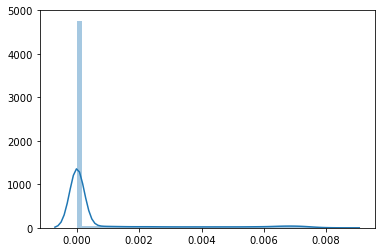

In [113]:
import seaborn as sns

sns.distplot(over_capacity)